02LRModel

In [1]:
import pandas as pd
import numpy as np
import os
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from helper_functions import *

Import data and drop selected features

In [2]:
with open('data/train_valid_test_data.pickle', 'rb') as f:
    train_df, valid_df, test_df = pickle.load(f)

''' 
Merge test and validation data.
'''
test_df = pd.concat([test_df,valid_df])

In [3]:
''' 
Drop features that have high percantage of missing values and 
have no noticable distribution differences.
'''

drop_cols = ["FiO2", "Bilirubin_direct", "SBP", "DBP", "Hct", "HospAdmTime", "ICULOS"] 

train_df.drop(train_df.columns[train_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test_df.drop(test_df.columns[test_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

In [4]:
print(train_df.shape)
print(test_df.shape)

(552371, 31)
(237844, 31)


In [5]:
def split_features_and_labels(df):
    cols = df.columns
    return np.array(df[cols[:-1]].values), df[cols[-1]].values

X_train, y_train = split_features_and_labels(train_df)
X_test, y_test   = split_features_and_labels(test_df)

In [6]:
pos_neg_train = len([1 for i in y_train if i == 1]) / len([1 for i in y_train if i == 0])
pos_neg_test  = len([1 for i in y_test if i == 1]) / len([1 for i in y_test if i == 0])

print("Sepsis positive vs sepsis negative ratio")
print(pos_neg_train)
print(pos_neg_test)

Sepsis positive vs sepsis negative ratio
0.0222656105415109
0.021934441584779515


Stand. and Normalize data.

In [7]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

Oversample minortiy class

In [8]:
# Split train dataset to sepsis positive and sepsis negative dataframe.
train_df_0 = train_df[train_df["SepsisLabel"] == 0]
train_df_1 = train_df[train_df["SepsisLabel"] == 1]

train_df_1_oversampled = train_df_1.sample(train_df_0.shape[0], replace = True) # Oversample sepsis positive patient by duplicating instances
train_df_oversampled = pd.concat([train_df_0, train_df_1_oversampled], axis = 0) # Create new training dataset, by concatinating trainf_df_0 and train_df_1_oversampled

X_train_os, y_train_os = split_features_and_labels(train_df_oversampled)

Fit logistic regression model on oversampled dataset

In [9]:
CROSS_VALID_FOLDS = 10

logreg = linear_model.LogisticRegression(solver='saga', max_iter=1000, verbose = True, n_jobs = 4)

hyper_parameter_options = dict(C=np.logspace(-1, 4, 10), penalty=['l1', 'l2'])
clf = RandomizedSearchCV(
                        logreg,
                        hyper_parameter_options,
                        cv = CROSS_VALID_FOLDS,
                        verbose = True,
                        n_jobs = 4
                        )
'''
best_logreg = clf.fit(X_train_os, y_train_os)
'''

'\nbest_logreg = clf.fit(X_train_os, y_train_os)\n'

In [10]:
with open("models/log_reg_oversample.pkl", "rb") as f:
    logreg_os = pickle.load(f)

#with open("models/log_reg_oversample.pkl", "wb") as f:
#    pickle.dump(best_logreg,f)

In [11]:
print("Selected Hyper parameters")
print("Parameters: " + str(logreg_os.best_params_))
print("Score: "      + str(logreg_os.best_score_))

Selected Hyper parameters
Parameters: {'penalty': 'l2', 'C': 774.2636826811278}
Score: 0.6624070029981123


Evaluate Model peformance

In [12]:
display_performance(logreg_os, X_test,y_test)

Accuarcy  = 0.5109063083365567
Recall    = 0.7463271302644466
Precision = 0.03205910318655705
F1Score   = 0.06147739374576435
F2Score   = 0.1367915383124017


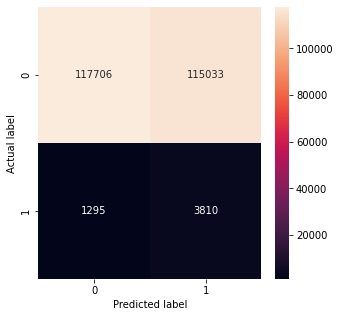

AUC: 0.6862581785326746


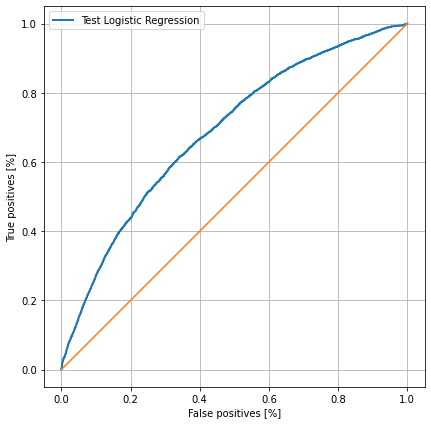

AUC: 0.0465569983035745


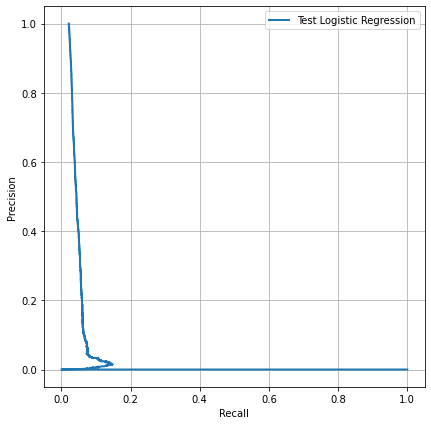

In [13]:
predictons_proba = logreg_os.predict_proba(X_test)[: , 1]
predictions      = logreg_os.predict(X_test)
plot_cm(y_test, predictions)
plot_roc("Test Logistic Regression", y_test, predictons_proba)
plot_prc("Test Logistic Regression", y_test, predictons_proba)

Synthetic Minority Oversampling Technique (SMOTE)

In [14]:
with open('data/train_valid_test_data.pickle', 'rb') as f:
    train_df, valid_df, test_df = pickle.load(f)

''' 
Merge test and validation data.
'''
test_df = pd.concat([test_df,valid_df])

In [15]:
''' 
Drop features that have high percantage of missing values and 
have no noticable distribution differences.
'''

drop_cols = ["FiO2", "Bilirubin_direct", "SBP", "DBP", "Hct", "HospAdmTime", "ICULOS"] 

train_df.drop(train_df.columns[train_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test_df.drop(test_df.columns[test_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

In [16]:
def split_features_and_labels(df):
    cols = df.columns
    return np.array(df[cols[:-1]].values), df[cols[-1]].values

X_train, y_train = split_features_and_labels(train_df)
X_test, y_test   = split_features_and_labels(test_df)

In [17]:
pos_neg_train = len([1 for i in y_train if i == 1]) / len([1 for i in y_train if i == 0])
pos_neg_test  = len([1 for i in y_test if i == 1]) / len([1 for i in y_test if i == 0])

print("Sepsis positive vs sepsis negative ratio")
print(pos_neg_train)
print(pos_neg_test)

Sepsis positive vs sepsis negative ratio
0.0222656105415109
0.021934441584779515


In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority') 

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [19]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [20]:
print("Sepsis positive vs sepsis negative ratio")
print(len([1 for i in y_train_smote if i == 1]) / len([1 for i in y_train_smote if i == 0]))
print(X_train_smote.shape)

Sepsis positive vs sepsis negative ratio
1.0
(1080680, 30)


Train logistic regression on SMOTE dataset

In [21]:
'''
Find best logistic regression model, using oversampled train data.
'''
CROSS_VALID_FOLDS = 10

logreg = linear_model.LogisticRegression(solver='saga', max_iter=1000, verbose = 1, n_jobs = 4)

hyper_par_options = dict(C = np.logspace(-1, 4, 10), penalty=['l1', 'l2'])
clf = RandomizedSearchCV(logreg, 
                        hyper_par_options,
                        cv = CROSS_VALID_FOLDS,
                        verbose = 1,
                        n_jobs = 4)
'''
best_logreg_smote = clf.fit(X_train_smote, y_train_smote)
'''

'\nbest_logreg_smote = clf.fit(X_train_smote, y_train_smote)\n'

In [22]:
with open("models/log_reg_smote.pkl", "rb") as f:
    best_logreg_smote = pickle.load(f)

#with open("models/log_reg_smote.pkl", "wb") as f:
#    pickle.dump(best_logreg_smote,f)

In [23]:
print("Selected Hyper parameters")
print("Parameters: " + str(best_logreg_smote.best_params_))
print("Score: " + str(best_logreg_smote.best_score_))

Selected Hyper parameters
Parameters: {'penalty': 'l1', 'C': 0.1}
Score: 0.6625957730317948


Evalute model performance

In [24]:
display_performance(best_logreg_smote, X_test,y_test)

Accuarcy  = 0.6651670843073612
Recall    = 0.6783545543584721
Precision = 0.04251218404350655
F1Score   = 0.08001016588882214
F2Score   = 0.16995651704472953


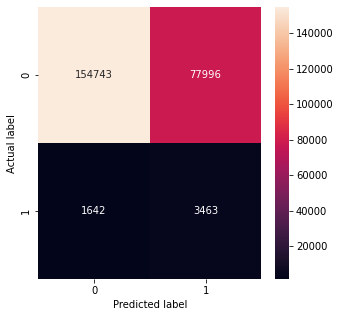

AUC: 0.7292491327535712


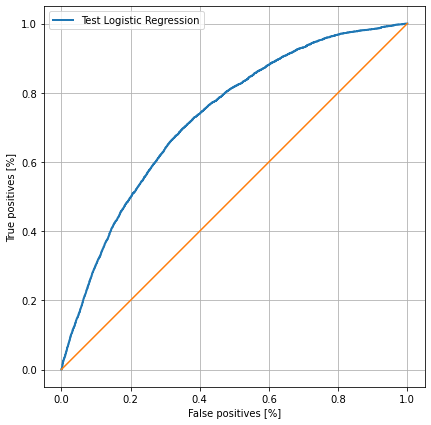

AUC: 0.05118878008363083


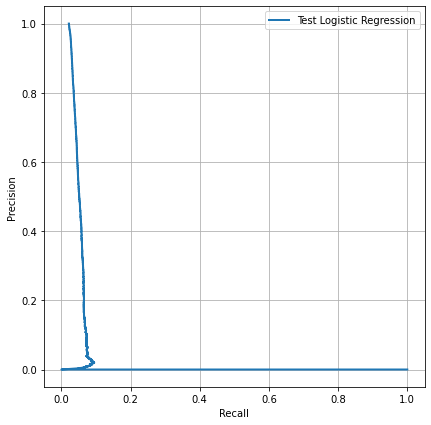

In [25]:
predictons_proba = best_logreg_smote.predict_proba(X_test)[: , 1]
predictions      = best_logreg_smote.predict(X_test)

plot_cm(y_test, predictions)
plot_roc("Test Logistic Regression", y_test, predictons_proba)
plot_prc("Test Logistic Regression", y_test, predictons_proba)